# Songs recommendation with GNN

Graph Neural Networks (GNNs) have recently gained increasing popularity in both research and real-world applications, therefore I decided to test several models in order to learn from the lyrics and from some other features of the songs, which are the ones related to each other.

The key idea of GNNs is to leverage the graph structure to update the node embedddings based on the local neighborhood around each node. By propagating these embeddings across the graph multiple times, it begins to incorporate information from both the local neighborhood and the more global one.

Like other neural networks, GNN architectures are composed by multiple layers, each layer can be split in three parts:
- ***message***: for a given central node, each neighbor passes its current embedding (that can be processed by a function) to the central node;
- ***aggregation***: the messages from the neighbors are aggregated to produce a single embedding (e.g. sum, average, max);
- ***update***: in this step the embedding of node *i* at the previous layer is combined with the neighborhood aggregation at the current layer.

In the section about the models I will explain the characteristics of the models that I chose to test.


In [81]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installation of the libraries and download of the datasets

As dataset I used a subset of the [Million Songs Dataset](http://millionsongdataset.com/), created by combining the musiXmatch and the Last.fm versions to retrieve the song lyrics and the similar songs respectively. You can download the script that create the dataset from Drive and execute it to create also the datasets for the analysis on R.

For the creation of the models I used the [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) library, because is probably the most efficient and well supported tool for dealing with GNNs.

In [1]:
import os
import torch

os.environ['TORCH'] = torch.__version__
print(f"torch version: {torch.__version__}")

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-geometric -f https://data.pyg.org/whl/torch-${TORCH}.html

!pip install --upgrade --no-cache-dir -q gdown
import gdown

torch version: 1.13.1+cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 16.9 MB/s eta 0:00:00


In the following cells you can choose either to download and create the dataset, elaborating the data from the Million Song Dataset (also using the musiXmatch and the Last.fm versions) or to copy the already created files from Drive.

In [ ]:
#@title #### Load the files from Drive
#@markdown Download the file for the training of the GNNs from Drive.

# File ids in Drive
url_train_data = "1-1I90HW0wZ1eVgXX9KETgEgYcnvJ0qAg"

gdown.download(id=url_train_data, output="songs_train.csv", quiet=False)

In [ ]:
#@title #### Download the script and create the datasets
#@markdown It first downloads the script and then it executes it to create the needed datasets.
#url_script = ""
#gdown.download(id=url_script, output="create_dataset.py", quiet=True)

!python create_dataset.py

The downloaded files, or the created variables, are not suitable to work with PyG, therefore I made some preprocessing on the dataframe in order to create the nodes and the edges of the GNN.

## Preprocessing to create graph data

As said before, the downloaded dataframe is not usable for creating the GNN, I have to preprocess the data in a specific way, creating the ids for the nodes, generating the edges and computing the features to use for these elements. First of all let's import all the needed libraries.

In [212]:
# Import the PyG modules
from torch_geometric import seed_everything
from torch_geometric.data import Data, Dataset, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, GCNConv, SAGEConv
from torch_geometric.nn.conv import MessagePassing
import torch_geometric.transforms as T
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling

import torch.nn.functional as F

# Basic modules to deal with dataframe
import pandas as pd
import numpy as np
import json
import random
import matplotlib.pyplot as plt

# Scikit-learn modules to create song lyrics embeddings
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Monitor the progress of the functions
from tqdm import tqdm
tqdm.pandas()
# Avoid warnings
pd.options.mode.chained_assignment = None

# nltk preprocessing to remove stopwords
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Set a seed for every random operation
seed_everything(88)

If you don't want to perform the preprocessing from scratch, you can download the pre-saved files that I already created executing the following cell.

### Download the preprocessed files
Download the files from Drive with the data that is ready to be used in order to create the graph features.

Download the files from Drive avoiding to run the preprocessing operations and load them into some variables.

In [218]:
url_graph_data = "1WKrN3NpXNdIovXdwEeGH9ZEUUYNOVI6j"
url_core_mapping = "1-3K1BqkUItn93_m7Wq1QGvESAXrt0RCd"
url_track_id_mapping = "1-548e0dADOLkbRoirJVTw5I2_ni1Ldif"
url_reduced_df = "1kAu3-jWOYpcNq2cBBsyr4pPOXLmf1gj9"

file_names = ['graph_data.pt', 'core_mapping.json', 'track_id_mapping.json', 
              'reduced_df.csv']

for name, url_id in zip(file_names, 
                        [url_graph_data, url_core_mapping, url_track_id_mapping,
                         url_reduced_df]):
    # If graph data, put into raw to preprocess with the dataset 
    if name == file_names[0]:
        if not os.path.exists('raw'):
            os.mkdir('raw')
        name = os.path.join('raw', name)

    gdown.download(id=url_id, output=name, quiet=True)

After having loaded the pre-saved files from Drive, execute the following cell to have the data loaded in the variables.

In [4]:
reduced_df = pd.read_csv(file_names[3])

with open(file_names[1], 'r') as fin1, open(file_names[2], 'r') as fin2:
    core_mapping = json.load(fin1)
    id_mapping = json.load(fin2)

graph_data = torch.load(os.path.join('raw', file_names[0]))

# The mappings to retrieve the correct ids
track_to_id, id_to_track = id_mapping['track_to_id'], id_mapping['id_to_track']
old_to_core_id, core_to_old_id = core_mapping['old_to_core_id'], core_mapping['core_to_old_id']

At this point you can skip the preprocessing part and go to the 'Models' section.

### Execute preprocessing
Execute the preprocessing from scratch (~ 15 minutes).

In the following cells there are all the needed passages to build the files that I also saved to Drive.

In [ ]:
#@title #### Preprocessing useful functions
#@markdown I implemented different functions to make the preprocessing operations.
def check_evaluation_dataset(target, track_id_list):
    '''
        It removes from the target string all the similar songs that are not
        in our main dataset.
    '''
    target_list = target.split(',')
    # We need to preserve the order of relevance for computing the mAP
    present = sorted(set(target_list).intersection(track_id_list), key=target_list.index)
    return ','.join(present)


def remove_stopwords(text, stop):
    '''
        It returns the string without the words within the list 'stop'.
    '''
    result = ' '.join([word for word in text.split(" ") if word not in stop])
    return result


def project_text_lsa(text, vocabulary, words_matrix):
    '''
        It projects a given text in the latent space, it first computes the TF-IDF
        vector considering the same vocabulary used to build the latent space and 
        then it projects the vector using the transpose words matrix. 
    '''
    vectorizer = TfidfVectorizer(vocabulary=vocabulary)

    tf_idf_vector = torch.tensor(vectorizer.fit_transform([text]).toarray(), dtype=torch.float32)

    # Compute the projection
    ls_vector = tf_idf_vector @ words_matrix.t()

    return ls_vector


def map_string_ids_to_num(str_list, mapping):
    conversion = str_list
    for tid in str_list.split(","):
        if tid in mapping:
            conversion = conversion.replace(tid, str(mapping[tid]))
        else:
            # Remove ids that are not in the dataset
            conversion = conversion.replace(f'{tid},', '')
    return conversion

The needed operations, before to create the graph, are the following:
- remove the NA elements from the dataframe;
- keep only the nodes with a number of similar songs between 5 and 75 in order to reduce the dataset;
- remove the stopwords from the lyrics;
- check that in the similar song lists there are songs still present in the dataset.

In [ ]:
train_df = pd.read_csv('songs_train.csv')
print(f"The length of the dataframe is {len(train_df)}.\n")

train_df = train_df.dropna()
# Keep only the nodes that have between 5 and 50 similar songs (edges)
reduced_df = train_df[(train_df['similars'].str.split(',').apply(len) >= 5) & (train_df['similars'].str.split(',').apply(len) <= 75)]

# Remove the stopwords from the lyrics
tqdm.pandas(desc="- Removing stopwords from lyrics")
reduced_df['lyrics'] = reduced_df['lyrics'].progress_apply(remove_stopwords, stop=stop)

# Check and keep only the lyrics with at least one word
reduced_df = reduced_df[~(reduced_df['lyrics'] == "")]
tqdm.pandas(desc="- (1) Keep only similar songs that are in the dataset")
reduced_df['similars'] = reduced_df['similars'].progress_apply(check_evaluation_dataset, track_id_list=reduced_df['track_id'].tolist())

# Remove the songs that are without similars
reduced_df = reduced_df[~(reduced_df.similars == "")].reset_index(drop=True)
# Last check after removal of songs without similars
tqdm.pandas(desc="- (2) Keep only similar songs that are in the dataset")
reduced_df['similars'] = reduced_df['similars'].progress_apply(check_evaluation_dataset, track_id_list=reduced_df['track_id'].tolist())

print(f"\n\nThe length of the reduced dataframe is {len(reduced_df)}.")

The length of the dataframe is 105031.



- Removing stopwords from lyrics: 100%|██████████| 99086/99086 [00:24<00:00, 4080.77it/s]
- (1) Keep only similar songs that are in the dataset: 100%|██████████| 99076/99076 [03:01<00:00, 545.03it/s]
- (2) Keep only similar songs that are in the dataset: 100%|██████████| 99073/99073 [02:51<00:00, 576.82it/s]



The length of the reduced dataframe is 99073.


After the previous steps I create a numerical id for the songs.

In [ ]:
# Encode each song with a numerical ID
item_encoder = LabelEncoder()
reduced_df['item_id'] = item_encoder.fit_transform(reduced_df['track_id'])

I also created a mapping to convert from string ids to numerical ones and viceversa, then I apply the conversion to the similar song lists.

In [ ]:
# Create the mapping from track_id to item_id and viceversa
track_to_id = {}
id_to_track = {}
for tid, iid in zip(reduced_df['track_id'], reduced_df['item_id']):
    track_to_id[tid] = iid
    id_to_track[iid] = tid

# Convert the list of similar songs to list of numerical ids
tqdm.pandas(desc="Convert similar songs track ids to numerical ids")
reduced_df['similars'] = reduced_df['similars'].progress_apply(map_string_ids_to_num, mapping=track_to_id)

Convert similar songs track ids to numerical ids: 100%|██████████| 99073/99073 [00:03<00:00, 26054.00it/s]


After all this operations I can create the graph structure that I will use later for the GNN model.

#### Creation of the nodes and edges data

To create the graph in a simple way, I decided to use the snap library from Stanford, that allows to work with graphs and to perform some operations on them.

In [ ]:
!pip install -q snap-stanford

# Install snap for simple graph creation
import snap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 91.8 MB/s eta 0:00:00


In [ ]:
# Create an undirected graph instance
G = snap.snap.TUNGraph().New()

# First add all song IDs as nodes in G
for i in tqdm(range(len(reduced_df))):
    song = int(reduced_df.loc[i, 'item_id'])
    if not G.IsNode(song):
        G.AddNode(song)
    # Add a node for each similar song and then add the edge
    for sim in reduced_df.loc[i, 'similars'].split(","):
        if not G.IsNode(int(sim)):
            G.AddNode(int(sim))
        G.AddEdge(song, int(sim))

print("Original graph:")
print(f"Num nodes: {len([x for x in G.Nodes()])} ({len(reduced_df['item_id'])} unique songs)")
print(f"Num edges: {len([x for x in G.Edges()])} (undirected)")

100%|██████████| 99073/99073 [00:12<00:00, 7625.78it/s]


Original graph:
Num nodes: 99073 (99073 unique songs)
Num edges: 3074999 (undirected)


In order to avoid the usage of a huge graph I decided to compute the K-core of my graph. The K-core of a graph G is the largest possible connected subgraph of G, in which every node has a degree of at least K. This will return the largest subgraph in which each song has at least K similar songs.

This operation has two advantages, it reduces the size of the dataset and it removes the songs that are not important for our analysis.

In [ ]:
K = 42
kcore = G.GetKCore(K)
if kcore.Empty():
    raise Exception(f"No Core exists for K={K}")

print("K-core graph:")
print(f"Num nodes: {len([x for x in kcore.Nodes()])} (and unique songs)")
print(f"Num edges: {len([x for x in kcore.Edges()])} (undirected)")

K-core graph:
Num nodes: 13742 (and unique songs)
Num edges: 562448 (undirected)


I need to re-index the nodes from 0 to n to avoid problem with PyG and I save the mapping such that I will be able to convert the new ids to the original ones.

In [ ]:
# We need to re-index the nodes, otherwise some problems later with PyG
old_to_core_id = {}
core_to_old_id = {}
for i, NI in enumerate(kcore.Nodes()):
    old_id = NI.GetId()
    assert old_id not in old_to_core_id
    new_id = i
    old_to_core_id[old_id] = new_id
    core_to_old_id[new_id] = old_id 

Now I can convert the given graph structure to the one compatible with PyG and I create a Data object.

In [ ]:
# Convert snap graph to a format that can be used in PyG, converting to edge_index and storing in a PyG Data object
all_edges = []
for EI in tqdm(kcore.Edges()):
    edge_info = [old_to_core_id[EI.GetSrcNId()], old_to_core_id[EI.GetDstNId()]]
    all_edges.append(edge_info)
    # Also add the edge in the opposite direction because undirected
    all_edges.append(edge_info[::-1]) 
edge_idx = torch.LongTensor(all_edges)

graph_data = Data(edge_index=edge_idx.t().contiguous(), num_nodes=kcore.GetNodes())

562448it [00:02, 237050.85it/s]


In order to use these data in a future run I save reduced_df, graph_data and the mappings in some files that I put on Drive. 

In [ ]:
# Save Data object (for training model) and the reduced df for retrieving info about the songs in the future
torch.save(graph_data, 'graph_data.pt')
# Save the reduced df and the mapping from one index to another
reduced_df.to_csv('reduced_df_GNN.csv', index=False)
core_mapping = {'old_to_core_id': old_to_core_id, 'core_to_old_id': core_to_old_id}
id_mapping = {'track_to_id': track_to_id, 'id_to_track': id_to_track}

with open('core_mapping.json', 'w') as fp1, open('track_id_mapping.json', 'w') as fp2:
    json.dump(core_mapping, fp1)
    json.dump(id_mapping, fp2)

### Create graph features to use in the GNN 
Create the node features from the preprocessed data, computing the latent space, then create the dataset and split the edges in train, validation and test.

In my case I want to exploit information from song lyrics, therefore I decided to compute a latent space, as in the analysis done with R, to build the feature matrix from them.

In [5]:
def compute_LSA(corpus, max_features_tfidf=2000, k_svd=200):
    '''
        It returns the documents matrix multiplied by the singular values, both
        computed using SVD truncated at k_svd.

        Parameters:
            - corpus: pd.Series
                The pandas series where the function will find the texts you want
                to use for the creation of the matrix.
            - max_features: int
                The maximum number of features to use for the TF-IDF matrix.
            - k_svd: int
                The number at which truncate the SVD matrix.
            
        Returns:
            - dict, torch.tensor
                It returns the dictionary used in the TF-IDF matrix, the tensor
                U * sigma of the SVD decomposition, i.e. the documents matrix, and
                the transpose of the terms matrix.
    '''
    # The number of terms to keep, almost half in this case
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features_tfidf)
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
    
    # Specify the number of latent dimensions
    lsa = TruncatedSVD(n_components=k_svd)
    
    # Apply the truncatedSVD function, the fit_transform function returns U*sigma
    documents_lsa = lsa.fit_transform(tfidf_matrix) 
    # Shape of the reduced matrix
    print(f"The documents matrix after the SVD decomposition has shape {documents_lsa.shape}")

    # Normalize the vectors
    documents_lsa = Normalizer(copy=False).fit_transform(documents_lsa)

    return tfidf_vectorizer.vocabulary_, torch.tensor(documents_lsa, dtype=torch.float32), torch.tensor(lsa.components_, dtype=torch.float32)

In [6]:
songs_vocabulary, songs_lsa, terms_lsa = compute_LSA(reduced_df['lyrics'], max_features_tfidf=2000, k_svd=200)

The documents matrix after the SVD decomposition has shape (75645, 200)


At this point I have all the needed information to create an ***InMemoryDataset*** that manages the data.

In [7]:
class MSongsDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(MSongsDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        # Retrieve the information about the edges
        return 'graph_data.pt'

    @property
    def processed_file_names(self):
        return 'processed_data.pt'

    def download(self):
        if not os.path.exists('raw/'):
            os.mkdir('raw')
        url_graph_data = "1WKrN3NpXNdIovXdwEeGH9ZEUUYNOVI6j"
        gdown.download(id=url_graph_data, output="raw/graph_data.pt", quiet=True)

    def process(self):
        # Check if the variable exists, otherwise import data
        try: graph_data = graph_data
        except: graph_data = torch.load(f'raw/{self.raw_file_names}')

        # Take the embeddings of the songs within the k-core
        if isinstance(list(core_to_old_id.keys())[0], str):
            core_ids = [core_to_old_id[str(node.item())] for node in torch.unique(graph_data.edge_index[0,:])]
        else:
            core_ids = [core_to_old_id[node.item()] for node in torch.unique(graph_data.edge_index[0,:])]
        
        core_songs = songs_lsa[core_ids, :]

        data = Data(x=core_songs, edge_index=graph_data.edge_index)
        # Transform to sparse tensor if the transformation is given
        data = data if self.pre_transform is None else self.pre_transform(data)
        
        torch.save(self.collate([data]), self.processed_paths[0])

In [8]:
graph_dataset = MSongsDataset(root='.', transform=T.ToSparseTensor())

Processing...
Done!


I also need to consider the split in train, validation and test sets, when dealing with graph more attention is needed since if a node is in a split, I don't want to assign the nodes connected to it to another split, otherwise I would have information mismatch.

In this case I have to perform link prediction, therefore the split is done at the edge-level, I used some edges for the training and the other for validation and test and the latter ones are hidden during training. To split the edges I simply used the *RandomLinkSplit* function of PyTorch Geometric, moreover I also specify that the edges are undirected such that [1, 2] and [2, 1] will be put in the same split.

In [9]:
split = RandomLinkSplit(num_val=0.2, num_test=0.1, is_undirected=True,
                            add_negative_train_samples=False, neg_sampling_ratio=0.8, split_labels=True)
train_data, val_data, test_data = split(graph_dataset[0])

## GNN Models

There are different interesting GNN architectures that can be used in order to tackle the link prediction problem, I chose to implement a simple GCN as first model, to have a baseline, then I implemented several GraphSAGE versions because is one of the most spread GNN architectures and it's quite effective for recommendation tasks.

All the models are composed by a GNN and a link predictor, whose goal is obviously to predict, given 2 nodes, if there exists an edge between them.

In [10]:
# Save the embedding, adjacent nodes and number of nodes in variables and move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

emb = graph_dataset[0].x.to(device)
adj_t = graph_dataset[0].adj_t.to(device)
num_nodes = emb.size(0)

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

To evaluate the models, I decided to use different scores:
- **mAP@k**, because it's the main metric to check if the suggested songs are retrieved and ordered with a good ranking.
- **recall@k**, to check if the similar songs are retrieved, even if not ranked in the right way.
- **ROC AUC**, to summarize the ROC curve into a single number, in this case it represents how good is the model at distinguishing between existing and not existing edges.

Given that the predictor takes as input two nodes and it computes the probability that an edge exists, to compute the recall and the mAP, I need to create a list of destination nodes to compare for each song. After that I retrieved all the similar songs and I put them in the list, I add 20*k nodes that are not similar, otherwise the evaluation of the model would not be fair if there are a large number of similar nodes with respect to the totality. 


In [11]:
# Install torch metrics to use the auroc function
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 12.9 MB/s eta 0:00:00


In [213]:
#@title #### Test functions
#@markdown I implemented several functions in order to compute different metrics on the validation and test datasets.
#@markdown You will find the implementation for the mAP@k given a list of similar songs and the predictions, the recall@k
#@markdown and the area under the curve.
from torchmetrics.functional import auroc
from collections import defaultdict 

def get_similar_dict(edges, k, verbose=True):
    '''
        It returns the dictionary where for each node I have the list of connected
        (similar) ones.

        Parameters:
            - edges: torch.tensor
                The edges between the nodes.
            - k: int
                It is used to filter and keep only the songs with more than k similar
                songs.
        
        Returns:
            - dict
                The dictionary with the songs as key and the list of similar songs
                as values.
    '''
    vprint = print if verbose else lambda *args, **kwargs: None
    songs = {}
    # Iterate over the columns of the edges tensor (with dim. (2, N))
    for i in range(edges.size(1)):
        src = edges[0, i].item()
        dest = edges[1, i].item()
        # Save for each song the similar ones
        if src not in songs:
            songs[src] = []
        if dest not in songs:
            songs[dest] = []
        # We need to save in both way since the edges are undirected
        songs[src].append(dest)
        songs[dest].append(src)

    # Delete the songs with less than k links from the dictionary
    songs = {song: similar for song, similar in songs.items() if len(similar) >= k}
    if len(songs) < 200:
        vprint(f"WARNING: the function kept {len(songs)} songs.")
    return songs


def compute_AP_k(predictions, target, k):
    '''
        It computes the average precision at k for the given lists.

        Parameters:
            - predictions: list
                The list that contains the ids of the songs predicted as similar.
            - target: list
                The groundtruth list of similar songs.
            - k: int
                The value to compute the AP at.
            
        Returns:
            - float
                It returns the AP@k.
    '''
    score=count = 0

    # Take the minimum value between k and the number of predicted edges
    k = min(k, len(predictions))
    for i in range(1, k+1):
        if predictions[i-1] in target and predictions[i-1] not in predictions[0:(i-1)]:
            count += 1
            score = score + count/i 
    
    score = score / k
    return score


def compute_recall_k(predictions, target, k):
    '''
        It computes the recall at k for the given predictions and target labels.
    '''
    score=count = 0
    # Take the minimum value between k and the number of predicted edges
    k = min(k, len(predictions))
    # For each predicted song link
    for i in range(0, k):
        if predictions[i] in target and predictions[i] not in predictions[0:(i)]:
            count += 1
    
    recall = count / k
    return recall


def compute_metrics_k(songs_dict, destinations, predictions, k, metrics=['map']):
    '''
        It computes the mean average precision at k on a set of predictions and
        target labels.

        Parameters:
            - songs_dict: dict
                The dictionary with the songs as keys and the similar ones as values.
            - destinations: torch.tensor
                The destination nodes for which I computed the predictions [src, dest]
                for each song.
            - predictions: torch.tensor
                The tensor that contains the probability to have a link between each
                pair of nodes.
            - k: int
                The value to compute the metrics at.
            - metrics: list[str]
                A list of string to point out which metrics have to be computed.
        
        Returns:
            - dict
                It return a dictionary with the computed metrics.
    '''
    scores = defaultdict(list)
    # Iterate over the number of songs 
    for i in range(predictions.size(0)):
        # Take the id of the song
        song = list(songs_dict.keys())[i]
        # Retrieve the k most probable predicted links (edges)
        top_k_idx = torch.topk(predictions[i, :], k)[1]
        # Take the ids of the most probable predicted nodes
        predicted_k = destinations[i, top_k_idx]
        # The nodes similar to 'song'
        target_nodes = songs_dict[song][:k]

        # Compute the mAP
        if 'map' in metrics:
            # Compute the AP@k
            apk = compute_AP_k(predicted_k.tolist(), target_nodes, k)
            scores[f'mAP@{k}'].append(apk)
        # Compute the recall
        if 'recall' in metrics:
            recallk = compute_recall_k(predicted_k.tolist(), target_nodes, k)
            scores[f'recall@{k}'].append(recallk)

    for metric in scores.keys():
        # Compute the average over the song of each metric
        scores[metric] = np.mean(scores[metric])

    return dict(scores)


@torch.no_grad()
def test_model(model, predictor, embeddings, adj_t, test_data, k, metrics=['map'],
               num_comp=15, edge_model=False, spd=None):
    '''
        It tests the model and it returns different selected metrics, given the 
        model and the predictor.

        Parameters:
            - model:
                The GNN model that creates the embeddins for the nodes.
            - predictor:
                The predictor that returns the probability of a link for each pair
                of nodes.
            - embeddings: torch.Tensor
                The embeddings of the nodes.
            - adj_t: torch.Tensor
                The sparse matrix that contains the edges.
            - test_data: torch_geometric.data.data.Data
                The data to use for the test.
            - k: int
                The k to use for computing the metric.
            - metric: list[str]
                A list of the metrics to compute, available ones are 'recall', 
                'map' and 'auc'.
            - num_comp: int
                The number of times to compute the metrics, and then take the average
                between these values.
            - edge_model: bool
                If the function should also pass the edge features to the model.
            - spd: torch.Tensor
                The tensor that contains the edge features.

        Returns:
            - dict
                It returns a dictionary that contains for each selected metric
                the score and the relative variance (given that it returns
                the mean on 20 different iterations).
    '''
    model.eval()
    predictor.eval()

    if edge_model:
        row, col, edge_attr = adj_t.t().coo()
        edge_index = torch.stack([row, col], dim=0)
        h = model(embeddings, edge_index, spd)
    else:
        h = model(embeddings, adj_t)

    # Create the dictionary that keep songs with at least k similar ones and the indices of the similars
    similar_songs = get_similar_dict(test_data.pos_edge_label_index, k)
    
    pos_eval_edge = test_data.pos_edge_label_index

    num_test_nodes = k*20
    scores = defaultdict(list)
    
    # Compute the metrics 'num_comp' times to have an average of the scores given
    # that I have obscillation due to the use of random negative sampling
    assert num_comp > 0, "ERROR: at least one iteration required for the computation of the metrics."
    for _ in range(num_comp):
        predictions = []
        destinations = []
        auc_labels = []
        for song, similars in similar_songs.items():

            sim_dest_nodes = torch.tensor(similars[:k]).to(device)
            # I have to choose wrong, random nodes, therefore I remove the similars from the choice
            rand_nodes = pos_eval_edge[0, torch.isin(pos_eval_edge[0,:], sim_dest_nodes, invert=True)]
            # The number of random nodes to take
            rand_num = num_test_nodes - len(sim_dest_nodes)
            rand_nodes = torch.tensor(random.sample(set(rand_nodes.cpu().tolist()), rand_num)).to(device)

            dest = torch.cat([sim_dest_nodes, rand_nodes])
            src = torch.full((len(dest), ), song).to(device)

            pred_song = predictor(h[src], h[dest]).squeeze().cpu()

            destinations.append(dest.cpu())
            predictions.append(pred_song)
            
            # Create the labels for compute the AUC
            pos_lab = torch.ones_like(sim_dest_nodes)
            neg_lab = torch.zeros_like(rand_nodes)
            auc_labels.append(torch.cat([pos_lab, neg_lab]))

        predictions = torch.stack(predictions).to(device)
        destinations = torch.stack(destinations).to(device)
        auc_labels = torch.stack(auc_labels).to(device)

        metrics_k = compute_metrics_k(similar_songs, destinations, predictions, k, metrics)
        # Compute the 'auc'
        if 'auc' in metrics:
            auc = auroc(predictions, auc_labels, task="binary").item()
            scores[f'AUROC@{k}'].append(auc)

        for metric in metrics_k.keys():
            scores[metric].append(metrics_k[metric])

    # Take the mean and the variance over 20 iterations for each metric
    for metric in scores.keys():
        scores[metric] = {'score': np.mean(scores[metric]),
                          'var': np.var(scores[metric])
                          }

    return scores


def print_scores(scores):
    '''
        It prints the scores given the dictionary returned by the test function.
    '''
    for metric, values in scores.items():
        print(f"The results for the {metric}:")
        print(f"- score: {round(values['score'], 6)}  - variance: {round(values['var'], 8)}\n")


def plot_loss(train_loss, val_loss, y_lim, figsize):

    plt.rcParams["figure.figsize"] = figsize

    plt.plot(train_loss, label="train loss")
    plt.plot(val_loss, label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("BCE loss")
    plt.legend(loc='upper right')
    plt.ylim(y_lim)
    plt.show()

In [13]:
#@title #### Training loop function
#@markdown The training loop where I used the positive training edges and I also sample negative edges, then I compute the 
#@markdown BCE loss on the predictions.
def create_train_batch(all_pos_train_edges, perm, edge_index):
    '''
        It returns a batch for the training, concatenating positive and negative
        samples.

        Parameters:
            - all_pos_train_edges: torch.tensor
                The tensor that contains the positive samples for the training.
            - perm: int
                The number of samples to take.
            - edge_index: torch.tensor
                All the available edges for the graph.
        
        Returns:
            - Tuple(torch.tensor, torch.tensor)
                It returns the edges to train on and the labels to compute the error.
    '''
    # First, we get our positive edges of dimensions (2, perm)     
    pos_edges = all_pos_train_edges[:, perm]

    # We then sample the negative edges using PyG functionality
    neg_edges = negative_sampling(edge_index, num_nodes=num_nodes,
                                  num_neg_samples=perm.shape[0], method='dense')

    # Our training batch is just the positive edges concatanted with the negative ones
    train_edge = torch.cat([pos_edges, neg_edges], dim=1)  

    # Our labels are all 1 for the positive edges and 0 for the negative ones                          
    pos_label = torch.ones(pos_edges.shape[1], )
    neg_label = torch.zeros(neg_edges.shape[1], )
    train_label = torch.cat([pos_label, neg_label], dim=0).to(device)

    return train_edge, train_label
  

@torch.no_grad()
def validation(model, predictor, node_emb, adj_t, val_data, loss_fn, edge_model=False,
               spd=None):
    '''
        This function evaluate the model on the validation dataset.

        Parameters:
            - model:
                The model to evaluate.
            - predictor:
                The predictor model to use for the edge predictions.
            - node_emb: torch.Tensor
                The node features tensor.
            - adj_t: torch.Tensor
                The sparse matrix that represents the edges between nodes.
            - val_data: torch.data.data.Data
                The validation edges.
            - loss_fn:
                The function to use for evaluating the model.
            - edge_model: bool
                It is true if the function has to pass the edge features to the model.
            - spd: torch.Tensor
                The tensor that contains the edge features.
    '''
    model.eval()
    predictor.eval()

    if edge_model:
        row, col, edge_attr = adj_t.t().coo()
        edge_index = torch.stack([row, col], dim=0)
        h = model(node_emb, edge_index, spd)
    else:
        h = model(node_emb, adj_t)

    all_pos_val_edges = val_data.pos_edge_label_index
    all_neg_val_edges = val_data.neg_edge_label_index

    val_loss = 0
    # Iterate over all the positive edges
    for perm in DataLoader(range(all_pos_val_edges.shape[1]), 32*1024, shuffle=True):

        pos_edges = all_pos_val_edges[:, perm]

        neg_idx = torch.randperm(all_neg_val_edges.size(1))[:len(perm)]
        neg_edges = all_neg_val_edges[:, neg_idx]

        # Our validation batch is just the positive edges concatanted with the negative ones
        val_edge = torch.cat([pos_edges, neg_edges], dim=1)  

        # Our labels are all 1 for the positive edges and 0 for the negative ones                          
        pos_label = torch.ones(pos_edges.shape[1], )
        neg_label = torch.zeros(neg_edges.shape[1], )
        val_label = torch.cat([pos_label, neg_label], dim=0).to(device)
        
        # Get predictions for our batch and compute the loss
        preds = predictor(h[val_edge[0]], h[val_edge[1]])
        loss = loss_fn(preds, val_label)

        val_loss += loss.item()

    return val_loss


def train(model, predictor, node_emb, adj_t, train_data, val_data, loss_fn, optimizer,
          scheduler, batch_size, num_epochs, verbose=False, edge_model=False, spd=None):
    '''
        It executes the training loop considering all the passed parameters.

        Parameters:
            - model
                It is the GNN model to create the embeddings.
            - predictor
                It is the link predictor model.
            - node_emb: torch.tensor
                It the tensor that contains the node embeddings.
            - adj_t: torch tensor
                It's the sparse matrix of edges.
            - train_data: torch_geometric.data.data.Data
                It is the set of edges and nodes to use for the training.
            - loss_fn: torch.nn.BCELoss
                It's the considered loss, in this case I used the BCELoss.
            - optimizer:
                The optimizer to use for the training.
            - scheduler:
                To change the learning rate when there is no significant update
                on the loss for several epochs.
            - batch_size: int
                The batch size to consider for the training.
            - num_epochs: int
                The number of epochs to consider for the training.
            - verbose: bool
                If verbose then the function will print every 5 epochs the statistics.
            - edge_model: bool
                If the function has to pass the edge features to the model.
            - spd: torch.Tensor
                The tensor that contains the edge features
        
        Returns:
            - tuple(list, list)
                It returns 2 lists with the training and validation losses.
    '''
    vprint = print if verbose else lambda *args, **kwargs: None
    # adj_t isn't used everywhere in PyG yet, so I switch back to edge_index for negative sampling
    row, col, edge_attr = adj_t.t().coo()
    edge_index = torch.stack([row, col], dim=0)

    model.train()
    predictor.train()

    model.reset_parameters()
    predictor.reset_parameters()

    # Take the positive edges for the training
    all_pos_train_edges = train_data.pos_edge_label_index
    losses = []
    val_losses = []
    vprint("Train the model ...\n")
    for epoch in range(num_epochs):
        epoch_total_loss = 0
        # Iterate over all the positive edges
        for perm in DataLoader(range(all_pos_train_edges.shape[1]), batch_size, shuffle=True):
            optimizer.zero_grad()

            train_edge, train_label = create_train_batch(all_pos_train_edges, perm, edge_index)
            
            # Use the GNN to generate node embeddings
            if edge_model:
                h = model(node_emb, edge_index, spd)
            else:
                h = model(node_emb, adj_t)

            # Get predictions for our batch and compute the loss
            preds = predictor(h[train_edge[0]], h[train_edge[1]])
            loss = loss_fn(preds, train_label)

            epoch_total_loss += loss.item()

            # Update our parameters
            loss.backward()
            # To avoid exploding gradient problem
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
            optimizer.step()

        val_loss = validation(model, predictor, node_emb, adj_t, val_data, loss_fn,
                              edge_model=edge_model, spd=spd)
        
        scheduler.step(val_loss)
        lr =  optimizer.param_groups[0]['lr']

        if (epoch+1) % 5 == 0:
            vprint(f'Epoch: {epoch+1} '
                    f' Lr: {lr:.7f} '
                    f' Loss: Train (BCE) = [{epoch_total_loss:.6f}] - Validation = [{val_loss:.6f}] ')            

        
        losses.append(epoch_total_loss)
        val_losses.append(val_loss)

    return losses, val_losses

### GCN with simple predictor

As explained before, the first model I implemented is simple GCN, followed by a link predictor network.    
GCNs can be categorized into ***spatial*** and ***spectral*** networks:
- spatial convolutions work on a local neighborhood of nodes and understand the properties of a node based on its k local neighbors;
- in spectral graph convolutions, the eigenvalue decomposition of the Laplacian matrix of the graph is performed, this help to understand the underlying structure of the graph.

The GCNConv layer, that I used, is implemented in PyG as a localized first-order approximation of spectral graph convolutions (from this [paper](https://arxiv.org/abs/1609.02907)).

One of the basic ways to evaluate message passing and update the value of a node $x$ in a GCN layer is:

$x_i' = Wx' + W \cdot \sum \limits_{j \in N(i) \cup (i)} \frac{x_j}{\sqrt{d_i d_j}}$

where $W$ is the matrix that contains the weights and $d$ is the node degree. The aggregation function is the sum of normalized node features, including node $i$, the update function is the sum between this value and the previous node embedding.

The link predictor is simply the dot product between the 2 nodes embeddings, followed by a sigmoid.

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        self.bns = torch.nn.ModuleList()
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(
                GCNConv(hidden_channels, hidden_channels))
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        self.convs.append(GCNConv(hidden_channels, out_channels))
        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, adj_t)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x


class DotProductLinkPredictor(torch.nn.Module):
    def __init__(self):
        super(DotProductLinkPredictor, self).__init__()

    def forward(self, x_i, x_j):
        out = (x_i*x_j).sum(-1)
        return torch.sigmoid(out)
    
    def reset_parameters(self):
        pass

After some tests I decided to use 256 as hidden dimension, to stack 5 layers and to use 0.3 as dropout. As optimizer I used Adam with a default learning rate of 0.001 but I also added a scheduler in order to decrease the learning rate by a factor of 0.2 after that the validation loss would not improve for 10 epochs, eventually I train the model for 50 epochs.

In [ ]:
hidden_dimension = 256

model = GCN(emb.size(1), hidden_dimension, hidden_dimension, 5, 0.3).to(device)
predictor = DotProductLinkPredictor().to(device)

In [ ]:
optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=10,
                                                        threshold=0.0001)

loss, val_loss = train(model, predictor, emb, adj_t, train_data, val_data, torch.nn.BCELoss(), 
                    optimizer, scheduler, 64 * 1024, 50, verbose=True)

Train the model ...

Epoch: 5  Lr: 0.0010000  Loss: Train (BCE) = [1.347222] - Validation = [1.323932] 
Epoch: 10  Lr: 0.0010000  Loss: Train (BCE) = [1.166790] - Validation = [1.129342] 
Epoch: 15  Lr: 0.0010000  Loss: Train (BCE) = [1.075241] - Validation = [1.044364] 
Epoch: 20  Lr: 0.0010000  Loss: Train (BCE) = [1.001836] - Validation = [0.979381] 
Epoch: 25  Lr: 0.0010000  Loss: Train (BCE) = [0.976822] - Validation = [0.947328] 
Epoch: 30  Lr: 0.0010000  Loss: Train (BCE) = [0.958798] - Validation = [0.931677] 
Epoch: 35  Lr: 0.0010000  Loss: Train (BCE) = [0.951711] - Validation = [0.924709] 
Epoch: 40  Lr: 0.0010000  Loss: Train (BCE) = [0.946971] - Validation = [0.923963] 
Epoch: 45  Lr: 0.0010000  Loss: Train (BCE) = [0.948512] - Validation = [0.923020] 
Epoch: 50  Lr: 0.0002000  Loss: Train (BCE) = [0.939177] - Validation = [0.905018] 


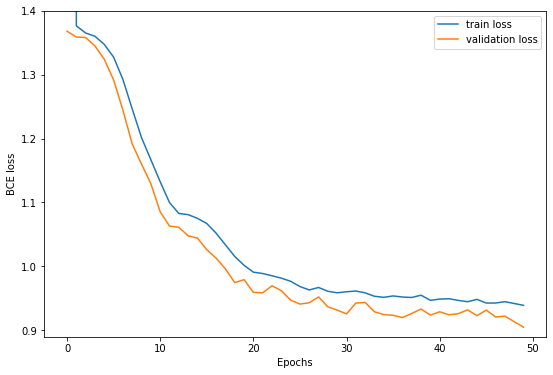

In [ ]:
plot_loss(loss, val_loss, (0.89, 1.4), (9, 6))

The different results are quite good but obviously I want to test more complex models in order to improve them.

In [ ]:
test_metrics = test_model(model, predictor, emb, adj_t, val_data, 20,
                          metrics=['auc', 'recall', 'map'], num_comp=10)

print_scores(test_metrics)

The results for the AUROC@20:
- score: 0.886143  - variance: 2.6e-07

The results for the mAP@20:
- score: 0.077349  - variance: 1.2e-06

The results for the recall@20:
- score: 0.185709  - variance: 1.94e-06



### GraphSAGE Baseline

It is characterized by a two-steps process of neighbor sampling and aggregation (along with a non-linearity) for creating node embeddings. Stacking successive layers allow nodes to increase their receptive field, i.e. to incorporate information from nodes that are distant. 
In GraphSAGE the *lth-layer* embedding for a node **v** is derived from the following equation:

$h_v^l = \sigma(W^l \cdot CONCAT(h_v^{l-1}, AGG(\{h_u^{l-1},\forall u \in N(v)\})))$

In the first stage, the messages from all the neighbors of v are aggregated (i.e. the embeddings from the (*l-1*)th layer are aggregated), moreover GraphSAGE has an additional step, aggregating the results from the neighbors with the v's embedding from the (*l-1*)th layer.

Then the $\sigma$ fuction can be any non-linearity (e.g. RELU) and AGG can be either a simple average or sum over all the messages, or it may incorporate a LSTM to act upon neighbors' embeddings.

Additionally, L2-normalization can be applied to the embeddings at each layer and also neighbors sampling in case of large graph where full-batch training is not feasible.

Once I have generated node embeddings using the GNN, I can then use the embeddings for any pair of nodes to predict whether they should be linked. I used as predictor the one declared in a previous cell, that simply computes the dot product of the two node embeddings, followed by a sigmoid.

In [15]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout, aggr="add"):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels, normalize=True, aggr=aggr))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels, normalize=True, aggr=aggr))
        self.convs.append(SAGEConv(hidden_channels, out_channels, normalize=True, aggr=aggr))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t):
        for conv in self.convs[:-1]:
            x = conv(x, adj_t)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x

In this first setup I considered as hidden dimensions 256, with 5 layers and 0.3 as dropout. I noticed that increasing the number of layers to 7, the model performed worse on the validation set, this overfitting was probably due to the complexity of the model with respect to the given number of nodes.

In [ ]:
# Initialize our model and LinkPredictor
hidden_dimension = 256
model = SAGE(emb.size(1), hidden_dimension, hidden_dimension, 5, 0.3).to(device)
predictor = DotProductLinkPredictor().to(device)

In [ ]:
# Initialize the optimizer and train the model
optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=10,
                                                        threshold=0.0001)

loss, val_loss = train(model, predictor, emb, adj_t, train_data, val_data, torch.nn.BCELoss(), 
                    optimizer, scheduler, 64 * 1024, 100, verbose=True)

In [ ]:
test_metrics = test_model(model, predictor, emb, adj_t, val_data, 20,
                          metrics=['auc', 'recall', 'map'], num_comp=5)

print_scores(test_metrics)

The results for the AUROC@20:
- score: 0.948806  - variance: 1.5e-07

The results for the mAP@20:
- score: 0.237373  - variance: 8.23e-06

The results for the recall@20:
- score: 0.424476  - variance: 1.696e-05



Training with these parameters I obtained quite good results, but in order to choose the best set of values I tried different combinations, on a training of 50 epochs.

In [ ]:
#@title #### Function to train multiple models with different parameters
def check_train_parameters(h_dim, n_layer, lr, emb, adj_t, train_data, val_data, 
                           test_data, epochs=50):
    ''' 
        It takes as input the list of parameters to check for each model.
        E.g. 
            h_dim = [256, 256, 512, 512, 1024]
            n_layer = [3, 5, 5, 7, 5]
            lr = [0.001, 0.001, 0.001, 0.001, 0.01]
        The function will first test the model with 256 as hidden dimension, 3 SAGE layers
        and lr = 0.001, then it will pass to the second element of each array etc.
    '''
    assert len(h_dim) == len(n_layer)
    assert len(n_layer) == len(lr)
    results = {}
    for mod in tqdm(range(len(h_dim)), desc="Training multiple models"):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Initialize our model and LinkPredictor
        model = SAGE(emb.size(1), h_dim[mod], h_dim[mod], n_layer[mod], 0.3).to(device)
        predictor = DotProductLinkPredictor().to(device)

        # Initialize the optimizer and train the model
        optimizer = torch.optim.Adam(
                    list(model.parameters())  +
                    list(predictor.parameters()), lr=lr[mod])

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=10,
                                                                threshold=0.0001)

        loss, val_loss = train(model, predictor, emb, adj_t, train_data, val_data, torch.nn.BCELoss(), 
                            optimizer, scheduler, 64 * 1024, epochs)
        
        metrics = test_metrics = test_model(model, predictor, emb, adj_t, test_data, 20, metrics=['auc', 'recall', 'map'], num_comp=5)
        results[mod] = {'parameters':{'lr':lr[mod], 'hidden_dim':h_dim[mod], 'n_layers':n_layer[mod]},
                        'train_loss': loss, 'val_loss': val_loss, 'metrics': metrics}
        del model
        del predictor
    return results

In [ ]:
h_dim = [256, 256, 512, 512, 1024]
n_layer = [5, 7, 5, 7, 5]
lr = [0.001, 0.001, 0.001, 0.001, 0.01]

res_mult_train = check_train_parameters(h_dim, n_layer, lr, emb, adj_t, train_data, val_data, val_data)

Training multiple models: 100%|██████████| 5/5 [01:58<00:00, 23.67s/it]


I plot the loss and the graph of the metrics computed on the training and validation datasets during the training.

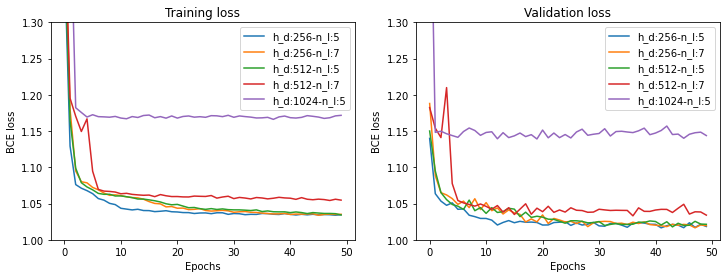

In [ ]:
def plot_losses(mod_results):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    for mod, values in mod_results.items():
        hid_dim = values['parameters']['hidden_dim']
        n_layers = values['parameters']['n_layers']
        axs[0].plot(values['train_loss'], label=f"h_d:{hid_dim}-n_l:{n_layers}")
        axs[1].plot(values['val_loss'], label=f"h_d:{hid_dim}-n_l:{n_layers}")

    axs[0].set_title('Training loss')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("BCE loss")
    axs[0].legend(loc='upper right')
    axs[0].set_ylim(1, 1.3)

    '''for mod, values in mod_results.items():
        hid_dim = values['parameters']['hidden_dim']
        n_layers = values['parameters']['n_layers']
        axs[1].plot(values['val_loss'], label=f"h_d:{hid_dim}-n_l:{n_layers}")'''

    axs[1].set_title('Validation loss')
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("BCE loss")
    axs[1].legend(loc='upper right')
    axs[1].set_ylim(1, 1.3)
    plt.show()

plot_losses(res_mult_train)

In [ ]:
df_mult_train = pd.DataFrame(columns=['AUROC@20', 'mAP@20', 'recall@20'])
aucs_mt, map_mt, recall_mt = [], [], []

for key in res_mult_train.keys():
    aucs_mt.append(res_mult_train[key]['metrics']['AUROC@20']['score'])
    map_mt.append(res_mult_train[key]['metrics']['mAP@20']['score'])
    recall_mt.append(res_mult_train[key]['metrics']['recall@20']['score'])

df_mult_train['AUROC@20'] = aucs_mt
df_mult_train['mAP@20'] = map_mt
df_mult_train['recall@20'] = recall_mt
df_mult_train.index = ['h_d: 256 - n_l: 3', 'h_d: 256 - n_l: 5', 'h_d: 512 - n_l: 5', 'h_d: 512 - n_l: 7', 'h_d: 1024 - n_l: 5']
df_mult_train

,AUROC@20,mAP@20,recall@20
h_d: 256 - n_l: 3,0.937753,0.227737,0.406159
h_d: 256 - n_l: 5,0.936721,0.214992,0.390460
h_d: 512 - n_l: 5,0.936412,0.219789,0.395016
h_d: 512 - n_l: 7,0.917931,0.152368,0.315159
h_d: 1024 - n_l: 5,0.735947,0.037465,0.073889


As you can notice from the table, the best results are obtained with the hidden dimensions equal to 256 and a small number of layers, 3 or 5. 

The results are much better than the ones obtained in the analysis with R, where I compared the embeddings of the songs with the other embeddings in order to get the most similar ones, but I still want to explore other solutions.

### GraphSAGE with post processing

Adding more layers onto a GNN can get detrimental because it may ends up with embeddings that are very similar each other (over-smoothing). I decided to try including post-processing layers in the GNN, which don't pass messages, but simply apply a neural network to the embeddings. This can be convenient when the embeddings need to be used in a downstream task, such as the link prediction I wish to perform.

In [ ]:
class PostProcessSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_dimension, out_channels, num_conv_layers,
                 num_linear_layers, dropout):
        super(PostProcessSAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.lins = torch.nn.ModuleList()
        
        self.convs.append(SAGEConv(in_channels, hidden_dimension, normalize=True, aggr="add"))
        for _ in range(num_conv_layers - 1):
            self.convs.append(SAGEConv(hidden_dimension, hidden_dimension, normalize=True, aggr="add"))
        
        for _ in range(num_linear_layers - 1):
            self.lins.append(torch.nn.Linear(hidden_dimension, hidden_dimension))
        self.lins.append(torch.nn.Linear(hidden_dimension, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t):
        for conv in self.convs[:-1]:
            x = conv(x, adj_t)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)

        # Post-process
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
        x = self.lins[-1](x)
        return x

In [ ]:
hidden_dimension = 256
linear_layers = 4

model = PostProcessSAGE(emb.size(1), hidden_dimension, hidden_dimension, 5, linear_layers, 0.3).to(device)
predictor = DotProductLinkPredictor().to(device)

In [ ]:
# Initialize the optimizer and train the model
optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=10,
                                                        threshold=0.0001, cooldown=2)

loss, val_loss = train(model, predictor, emb, adj_t, train_data, val_data, torch.nn.BCELoss(),
                          optimizer, scheduler, 64 * 1024, 100, verbose=True)

Train the model ...

Epoch: 5  Lr: 0.0010000  Loss: Train (BCE) = [1.386621] - Validation = [1.385348] 
Epoch: 10  Lr: 0.0010000  Loss: Train (BCE) = [1.377239] - Validation = [1.360666] 
Epoch: 15  Lr: 0.0010000  Loss: Train (BCE) = [1.166241] - Validation = [1.127687] 
Epoch: 20  Lr: 0.0010000  Loss: Train (BCE) = [1.146973] - Validation = [1.119173] 
Epoch: 25  Lr: 0.0010000  Loss: Train (BCE) = [1.134748] - Validation = [1.114432] 
Epoch: 30  Lr: 0.0010000  Loss: Train (BCE) = [1.133148] - Validation = [1.123280] 
Epoch: 35  Lr: 0.0010000  Loss: Train (BCE) = [1.121937] - Validation = [1.118484] 
Epoch: 40  Lr: 0.0010000  Loss: Train (BCE) = [1.120676] - Validation = [1.089701] 
Epoch: 45  Lr: 0.0010000  Loss: Train (BCE) = [1.113138] - Validation = [1.097352] 
Epoch: 50  Lr: 0.0010000  Loss: Train (BCE) = [1.105695] - Validation = [1.075407] 
Epoch: 55  Lr: 0.0010000  Loss: Train (BCE) = [1.094940] - Validation = [1.078602] 
Epoch: 60  Lr: 0.0010000  Loss: Train (BCE) = [1.071604]

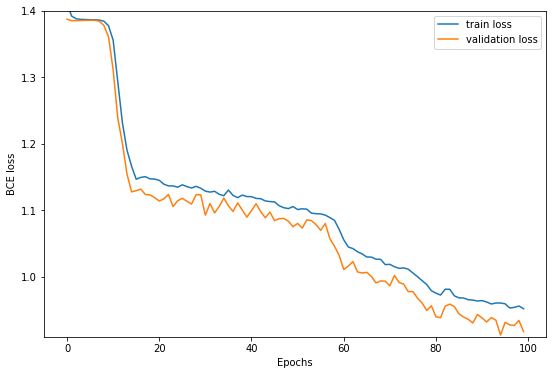

In [ ]:
plot_loss(loss, val_loss, (0.91, 1.4), (9, 6))

In [ ]:
test_metrics = test_model(model, predictor, emb, adj_t, val_data, 20,
                          metrics=['auc', 'recall', 'map'], num_comp=5)

print_scores(test_metrics)

The results for the AUROC@20:
- score: 0.899257  - variance: 4e-08

The results for the mAP@20:
- score: 0.074728  - variance: 1.34e-06

The results for the recall@20:
- score: 0.20311  - variance: 3.4e-07



This model performs worse than the GraphSAGE baseline, but it's better than the simple GCN model, probably because I introduced other layers in the postprocessing step that don't help in recognizing the edges that should exist, but they may introduce some more useful information than a basic convolution.

### GraphSAGE with neural link predictor

Changing the GNN model I was not able to improve my results, therefore I decided to implement a more clever link predictor, making use of a simple neural network. In this case I am trying to improve the quality of the predictions and not the quality of the created embeddings.

Although this seems similar to the post-processing I did previously, the limitation of the prior method was that the model had to generate individual node embeddings that could directly be used for making link predictions for all possible pairs of nodes. By instead having a LinkPredictor, as an independent neural network that can operate directly on pairs of nodes and take into account their unique interactions, this task becomes easier and the model becomes much more expressive (Inspired by [this code](https://github.com/snap-stanford/ogb/blob/master/examples/linkproppred/ddi/gnn.py)).

In [14]:
class NeuralLinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(NeuralLinkPredictor, self).__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        x = x_i * x_j
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x).squeeze()

I will test this predictor with the base SAGE model.

In [28]:
hidden_dimension = 256

model = SAGE(emb.size(1), hidden_dimension, hidden_dimension, 4, 0.3).to(device)
predictor = NeuralLinkPredictor(hidden_dimension, hidden_dimension, 1, 7, 0.3).to(device)

After some attempts I found that a good set of values for the training was:
- hidden_dimension = 256;
- 4 SAGEConv layers;
- 7 layers for the neural predictor;
- 0.3 dropout for both. 

In [ ]:
optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=10,
                                                        threshold=0.0001)

loss, val_loss = train(model, predictor, emb, adj_t, train_data, val_data, torch.nn.BCELoss(), 
                    optimizer, scheduler, 64 * 1024, 100, verbose=True)

Train the model ...

Epoch: 5  Lr: 0.0010000  Loss: Train (BCE) = [1.379302] - Validation = [1.370598] 
Epoch: 10  Lr: 0.0010000  Loss: Train (BCE) = [1.154892] - Validation = [1.062976] 
Epoch: 15  Lr: 0.0010000  Loss: Train (BCE) = [0.528709] - Validation = [0.487214] 
Epoch: 20  Lr: 0.0010000  Loss: Train (BCE) = [0.439357] - Validation = [0.425795] 
Epoch: 25  Lr: 0.0010000  Loss: Train (BCE) = [0.409876] - Validation = [0.397790] 
Epoch: 30  Lr: 0.0010000  Loss: Train (BCE) = [0.388909] - Validation = [0.383916] 
Epoch: 35  Lr: 0.0010000  Loss: Train (BCE) = [0.381350] - Validation = [0.380741] 
Epoch: 40  Lr: 0.0010000  Loss: Train (BCE) = [0.359964] - Validation = [0.347660] 
Epoch: 45  Lr: 0.0010000  Loss: Train (BCE) = [0.353261] - Validation = [0.343924] 
Epoch: 50  Lr: 0.0010000  Loss: Train (BCE) = [0.344126] - Validation = [0.332646] 
Epoch: 55  Lr: 0.0010000  Loss: Train (BCE) = [0.336787] - Validation = [0.327401] 
Epoch: 60  Lr: 0.0010000  Loss: Train (BCE) = [0.330363]

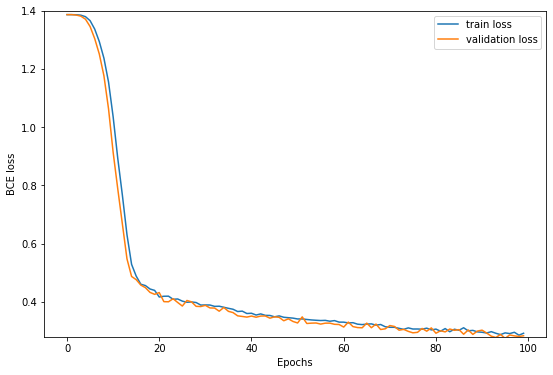

In [ ]:
plot_loss(loss, val_loss, (0.28, 1.4), (9, 6))

In [ ]:
test_metrics = test_model(model, predictor, emb, adj_t, val_data, 20,
                          metrics=['auc', 'recall', 'map'], num_comp=10)

print_scores(test_metrics)

The results for the AUROC@20:
- score: 0.963609  - variance: 6e-08

The results for the mAP@20:
- score: 0.25372  - variance: 7.69e-06

The results for the recall@20:
- score: 0.447119  - variance: 4.65e-06



With this predictor, I obtained better scores than with the post-processing model and the SAGE one, clearly a more expressive LinkPredictor can take the embeddings generated by our basic GNN and start making reasonably good predictions.

The AUC is better than the one computed with the SAGE + the DotProduct predictor, this means that the model is able to predict better if an edge is a positive or a negative sample and it is also able to suggest more similar songs because both the mAP and the recall increased. 

### GraphSAGE with edge features

The last thing that I want to try is to set some edge features, to check if this can lead to better suggestions.

Prior work by [Lu et al.](https://github.com/lustoo/OGB_link_prediction/blob/main/Link%20prediction%20with%20structural%20information.pdf) found that distance encoding methods may work well for some datasets, as nodes that are estimated to be close together have a higher chance of being connected by an edge, therefore I will use those distances as edge features between nodes.

Trying to calculate the shortest-path distances between all nodes can get computationally intractable. Instead, I can approximate distances by leveraging an anchor set of K randomly sampled nodes. I first calculate the distance from each of these K nodes to all other nodes in the graph. Then I use these distances to get a reasonable approximation of the distance between any two nodes in the graph.

$d_{u,v} \approx \frac{1}{K} \sum \limits_{k \in anchor} d_{k,u} + d_{k,v}$

I can create the matrix of anchor set distances using networkx library, but first I need to convert the PyTorch sparse tensors to a scipy matrix.

In [ ]:
import networkx as nx
import random

In [ ]:
scipy_mat = graph_dataset[0].adj_t.to_scipy(layout='coo')
graph_anch = nx.Graph(scipy_mat)

Naturally with larger values of K you get a better approximation of the distances between nodes, in my case I chose K=400 because it's a reasonable number for a set of ~6000 nodes.

In [ ]:
K = 400

sampled_nodes = sorted(random.sample(graph_anch.nodes, K))
spd = torch.ones(num_nodes, K, dtype=torch.float64)

for k in tqdm(range(K), desc="Computing node distances"):
    distance_from_sample_k_to_all_nodes = nx.shortest_path_length(graph_anch, source=sampled_nodes[k])
    for node in distance_from_sample_k_to_all_nodes:
        # For each node I have the distance from the k anchor nodes
        spd[node][k] = distance_from_sample_k_to_all_nodes[node]

spd = spd.float()
print(spd)

Computing node distances: 100%|██████████| 400/400 [00:19<00:00, 20.00it/s]

tensor([[0., 1., 1.,  ..., 1., 4., 1.],
        [1., 3., 4.,  ..., 4., 1., 2.],
        [1., 4., 4.,  ..., 4., 1., 2.],
        ...,
        [1., 3., 3.,  ..., 3., 1., 4.],
        [1., 4., 3.,  ..., 3., 1., 3.],
        [1., 4., 4.,  ..., 4., 1., 2.]])


In order to include the edge features I have to change the SAGEConv layer to implement the message passing that considers them, a similar implementation can be found at [this link](https://github.com/lustoo/OGB_link_prediction/blob/main/DDI/link_pred_ddi_graphsage_edge.py).

The message sent by a node $v$, neighbor of a node $u$ becomes:

$m_v^l = h_v^{l-1} + W_e \cdot d_{u,v}$


In [ ]:
class SAGEConvWithEdges(MessagePassing):
    def __init__(self, in_channels,
                 out_channels, normalize = False,
                 root_weight = True,
                 bias = True, **kwargs):  
        kwargs.setdefault('aggr', 'add')
        super(SAGEConvWithEdges, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.root_weight = root_weight

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_l = torch.nn.Linear(in_channels[0], out_channels, bias=bias)
        self.lin_e = torch.nn.Linear(1, in_channels[0], bias=bias)
        if self.root_weight:
            self.lin_r = torch.nn.Linear(in_channels[1], out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_e.reset_parameters()
        if self.root_weight:
            self.lin_r.reset_parameters()


    def forward(self, x, edge_index, spd, size = None):
        if isinstance(x, torch.Tensor):
            x = (x, x)
        # propagate() takes in the edge indices and all additional data which is
        # needed to construct messages and to update node embeddings
        out = self.propagate(edge_index, x=x, spd=spd)
        out = self.lin_l(out)
        
        x_r = x[1]
        if self.root_weight and x_r is not None:
            out += self.lin_r(x_r)
            
        if self.normalize:
          out = F.normalize(out, p=2., dim=-1)
        return out


    def message(self, x_j, spd_i, spd_j):
        dist_mean = torch.mean(spd_i + spd_j, 1, True)
        return F.relu(x_j + self.lin_e(dist_mean))


    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)

In [ ]:
class EdgeSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout, aggr="mean"):
        super(EdgeSAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConvWithEdges(in_channels, hidden_channels, normalize=True, aggr=aggr))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConvWithEdges(hidden_channels, hidden_channels, normalize=True, aggr=aggr))
        self.convs.append(SAGEConvWithEdges(hidden_channels, out_channels, normalize=True, aggr=aggr))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, edge_index, spd):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index, spd)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index, spd)
        return x

I tried different configurations for the model, but also in this case I noticed that the best one is with 256 as hidden dimension, 5 layers for the GNN model, 5 layers for the neural predictor, 0.4 of dropout and a learning rate of 0.001.

In this case I trained the model for 200 epochs given that the model is more complex than the previous ones.

In [ ]:
hidden_dimension = 256

spd = spd.to(device)

model = EdgeSAGE(emb.size(1), hidden_dimension, hidden_dimension, 5, 0.4).to(device)
predictor = NeuralLinkPredictor(hidden_dimension, hidden_dimension, 1, 5, 0.4).to(device)

In [ ]:
optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=10,
                                                        threshold=0.0001, cooldown=2)

loss, val_loss = train(model, predictor, emb, adj_t, train_data, val_data, torch.nn.BCELoss(), 
                    optimizer, scheduler, 64 * 1024, 200, edge_model=True, spd=spd, verbose=True)

Train the model ...

Epoch: 5  Lr: 0.0010000  Loss: Train (BCE) = [1.386257] - Validation = [1.386100] 
Epoch: 10  Lr: 0.0010000  Loss: Train (BCE) = [1.362568] - Validation = [1.345108] 
Epoch: 15  Lr: 0.0010000  Loss: Train (BCE) = [1.194772] - Validation = [1.150660] 
Epoch: 20  Lr: 0.0010000  Loss: Train (BCE) = [1.003526] - Validation = [0.984150] 
Epoch: 25  Lr: 0.0010000  Loss: Train (BCE) = [0.987594] - Validation = [0.973785] 
Epoch: 30  Lr: 0.0010000  Loss: Train (BCE) = [0.960727] - Validation = [0.948106] 
Epoch: 35  Lr: 0.0010000  Loss: Train (BCE) = [0.926305] - Validation = [0.915641] 
Epoch: 40  Lr: 0.0010000  Loss: Train (BCE) = [0.925343] - Validation = [0.916509] 
Epoch: 45  Lr: 0.0010000  Loss: Train (BCE) = [0.923700] - Validation = [0.900279] 
Epoch: 50  Lr: 0.0010000  Loss: Train (BCE) = [0.916540] - Validation = [0.892910] 
Epoch: 55  Lr: 0.0010000  Loss: Train (BCE) = [0.917222] - Validation = [0.894744] 
Epoch: 60  Lr: 0.0002000  Loss: Train (BCE) = [0.918787]

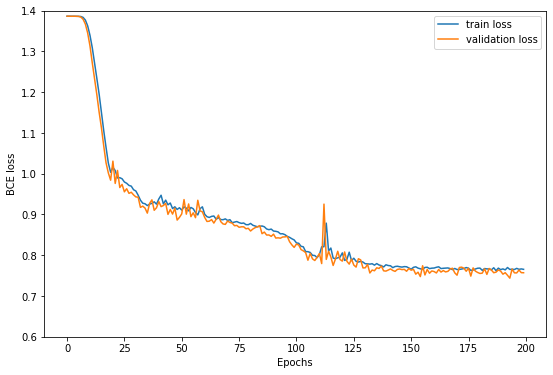

In [ ]:
plot_loss(loss, val_loss, (0.6, 1.4), (9, 6))

In [ ]:
#patiente 15, cooldown 5, 5 layers both
test_metrics = test_model(model, predictor, emb, adj_t, val_data, 20,
                          metrics=['auc', 'recall', 'map'], num_comp=10,
                          edge_model=True, spd=spd)

print_scores(test_metrics)

The results for the AUROC@20:
- score: 0.871444  - variance: 1.9e-07

The results for the mAP@20:
- score: 0.091039  - variance: 1.64e-06

The results for the recall@20:
- score: 0.212142  - variance: 2.28e-06



The final scores are worse than the ones obtained with the GraphSAGE and the NeuralPredictor, there could be different reasons for this behaviour. The main one is that I introduced further complexity but the model struggle a bit even with simpler model, due to the low number of nodes.

## Qualitative evaluation

My best model is the GraphSAGE one, used in combination with the NeuralLinkPredictor, at this point I want to test how it works in practice.

Up to now I only checked the scores obtained in the different metrics, but I also want to see if the suggested songs are actually similar to a given one. Therefore I wrote a simple function that predict the k most similar songs and return them. 

In [211]:
#@title #### Function to retrieve k most similar songs information
from IPython.display import display

@torch.no_grad()
def test_suggestions(model, predictor, embeddings, adj_t, test_data, k, reduced_df,
                     mapping_to_df, song=None, core_mapping=None):
    '''
        It tests the model returning the most similar songs to a given one.

        Parameters:
            - model:
                The GNN model that creates the embeddins for the nodes.
            - predictor:
                The predictor that returns the probability of a link for each pair
                of nodes.
            - embeddings: torch.Tensor
                The embeddings of the nodes.
            - adj_t: torch.Tensor
                The sparse matrix that contains the edges.
            - test_data: torch_geometric.data.data.Data
                The data to use for the test.
            - k: int
                It is the number of similar songs that the model has to return.
            - reduced_df: pd.DataFrame
                The dataframe from which the function will retrieve the information
                about the suggested songs.
            - mapping_to_df: dict
                The mapping to retrieve the item id from the core id.
            - song: int
                The item id of the song to test. If None, a random song is sampled.
            - core_mapping: dict
                If a song is passed, it's requested also to pass the dictionary with
                the mapping from item id to core id.
        Returns:
            - pd.DataFrame
                It returns the row of the dataframe with the song selected to be
                tested and a second dataframe with the similar songs.
    '''
    model.eval()
    predictor.eval()

    h = model(embeddings, adj_t)

    # Create the dictionary that keep songs with at least k similar ones and the indices of the similars
    similar_songs = get_similar_dict(test_data.pos_edge_label_index, k, verbose=False)
    pos_eval_edge = test_data.pos_edge_label_index
    num_test_nodes = k*20

    # Take one random song from the test set
    if song is None:
        available_songs = list(similar_songs.keys())
        test_song = available_songs[random.randint(0, len(available_songs))]
    else:
        # Check if the mapping has been passed and the song is part of the core graph
        try:
            if core_mapping == None:
                print("ERROR: you need to pass the mapping with the selected song.")
                return None, None
            test_song = core_mapping[str(song)]
        except:
            print("ERROR: the passed song is not part of the core graph.")
            return None, None

    # Take the songs similars to test_song and create a tensor
    similars_test = similar_songs[test_song]
    sim_dest_nodes = torch.tensor(similars_test[:k]).to(device)

    # I have to choose wrong, random nodes, therefore I remove the similars from the choice
    rand_nodes = pos_eval_edge[0, torch.isin(pos_eval_edge[0,:], sim_dest_nodes, invert=True)]
    rand_num = num_test_nodes - len(sim_dest_nodes)
    # Sample only unique nodes, selecting them among a set of the values
    rand_nodes = torch.tensor(random.sample(set(rand_nodes.cpu().tolist()), rand_num)).to(device)

    dest = torch.cat([sim_dest_nodes, rand_nodes])
    src = torch.full((len(dest), ), test_song).to(device)

    pred_songs = predictor(h[src], h[dest]).squeeze().cpu()

    # Retrieve the k most probable predicted links (edges)
    top_k_idx = torch.topk(pred_songs, k)[1]
    predicted_k = dest[top_k_idx].tolist()
    res_ids = [mapping_to_df[str(pred)] for pred in predicted_k]
    tested_song = mapping_to_df[str(test_song)]

    return pd.DataFrame(reduced_df.iloc[tested_song]).transpose(), reduced_df.iloc[res_ids]

In you don't pass any particular song to the function, it will automatically sample one random song from the k-core graph and it will return the most similar.

I show you an example in which the selected song comes from 'death metal' genre, to check if the suggested ones are related to it.

In [197]:
test_song, sim_songs = test_suggestions(model, predictor, emb, adj_t, test_data,
                                        20, reduced_df, core_to_old_id, song=48460,
                                        core_mapping=old_to_core_id)

In [198]:
print("The selected song is:")
display(test_song.loc[:,['title', 'artist_name', 'lyrics', 'tag']])
print("\nand have the following lyrics:\n")
display(test_song.lyrics.item())
print("\nThe similar songs are:")
display(sim_songs.loc[:,['title', 'artist_name', 'lyrics', 'tag']])

The selected song is:


,title,artist_name,lyrics,tag
48460,Lying With Demons,Immolation,come one one one never feel heart us fall arou...,death metal



and have the following lyrics:



'come one one one never feel heart us fall around hand hear cri soul thought break watch wrong fire breath mani death knew angel rise saw lay wast lead shadow shall devil desir weak forc tongu rage demon demon poison guid prove seek releas victim divin wick fever mass whose iron deceiv chosen righteous wrath tempt grasp scorn devast'


The similar songs are:


,title,artist_name,lyrics,tag
36277,Shine On Golden Sun,Lana Lane,come away eye right tell man man man well well...,Progressive metal
14092,Silence,Abydos,go go go oh one one one one never never feel s...,Progressive metal
40277,City of the Dead,Outworld,time come come way say take take eye live drea...,Progressive metal
30386,A Flower That Sears In Silence,How Like A Winter,love love love know see die live still still f...,doom metal
73588,A Sorrow To Kill,To-Mera,time go go go go let way way away away life ni...,Progressive metal
72809,The Conductors Departure,Anata,like like time come one one make say would wou...,death metal
6576,Sincerely,Ebony Ark,love love love go one never never feel feel ca...,Progressive metal
53461,Wicked World,Skinless,know go go got got say day day life world die ...,death metal
8996,Out In The Real World,Stream Of Passion,time de de de de de de la la la never never ma...,Progressive metal
39945,Just A Little,Ark,know know like like like like come go go go go...,Progressive metal


As you can see the suggested songs are all very related to the selected one, therefore my best model is able to predict which songs may be the most similar with respect to a given one with a good ratio. 

In the following cells I printed another example where the function took a random song from the available ones.

In [209]:
test_song, sim_songs = test_suggestions(model, predictor, emb, adj_t, val_data,
                                        20, reduced_df, core_to_old_id)

In [210]:
print("The selected song is:")
display(test_song.loc[:,['title', 'artist_name', 'lyrics', 'tag']])
print("\nand have the following lyrics:\n")
display(test_song.lyrics.item())
print("\nThe similar songs are:")
display(sim_songs.loc[:,['title', 'artist_name', 'lyrics', 'tag']])

The selected song is:


,title,artist_name,lyrics,tag
24888,Cergy,Anis,que que de de de de de la la la la la la la la...,french



and have the following lyrics:



'que que de de de de de la la la la la la la la la la la en en en en en en un un un un tu tu le le le le le le si si du place chang je et et et et et et et les les les les les les les les les les les sweet sweet sweet il qui qui qui pas pas pas pas pas pas pas pas pas pas pas pas pas est dan dan dan dan dan dan dan dan dan dan dan dan mai mai pour pour pour fill fill citi citi citi à à à à à à cest cest cest cest cest cest cest ni ni ni bien plus mon mon mon mon mon au au au comm comm une une une bell jai jai jai jai jai jai fair san ta vie regret grand grand grand grand ou ça ça mes mes ton calm temp temp tous mond même vill sont où faut fai amour peu bon ciudad 6 tour ici ici ici domin ont ont avant pot quelqu aussi winner tas tas gris jsui jsui jsui jsui jsui jsui fleur butt sil combin c\x9cur routin joli parc dautr premier'


The similar songs are:


,title,artist_name,lyrics,tag
60594,Regarde Moi,Dany Brillant,que que que que que que de de de de de la la l...,jazz
1297,Le poulet,Pierre Perret,que de de de de de la la la la en un un un se ...,chanson francaise
26274,Le Toi Du Moi,Carla Bruni,de de de de de de de de de de de de de la la l...,french
35052,Savoir,Louise Attaque,de de de de de de la la la la la la la la en t...,french
18844,Un Ane Plane,Alain Bashung,que que de de de la un un un un un un un te se...,french pop
18643,Les Matins D'Hiver,Gerard Lenorman,que de de de de de de de de de de la la en en ...,french
5017,Set Yourself On Fire,Charlotte Gainsbourg,like time come come come come one see see see ...,french
29192,Deux Pieds,Thomas Fersen,que que que que que que que que que que que qu...,nouvelle scene francaise
19566,C'est lui que mon coeur a choisi,Edith Piaf,que de la la en un le le le si si si si si du ...,Voice
30831,Ainsi Soit Je,Mylène Farmer,que que que que que que de de de de de de de d...,french
